In [47]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env
import numpy as np
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import warnings 
warnings.filterwarnings("ignore")
from pydataset import data
import wrangle as wg
pd.set_option('display.max_rows', 100)
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
np.random.seed(77)
pd.set_option('display.max_columns', None)
random_state = 77

In [2]:
df = wg.acquire()


In [3]:
def tidy(df):
    # drop redundant id code columns
    id_cols = [col for col in df.columns if 'typeid' in col or col in ['id', 'parcelid']]
    df = df.drop(columns=id_cols)
    # filter for single family properties
    df = df[df.propertylandusedesc == 'Single Family Residential']
    # drop specified columns
    cols_to_drop = ['calculatedbathnbr',
                    'finishedfloor1squarefeet',
                    'finishedsquarefeet12', 
                    'regionidcity',
                    'landtaxvaluedollarcnt',
                    'taxamount',
                    'rawcensustractandblock',
                    'roomcnt',
                    'regionidcounty',
                    'propertycountylandusecode',
                    'regionidzip',
                    'transactiondate',
                    'censustractandblock',
                    'threequarterbathnbr',
                    'assessmentyear']
    df = df.drop(columns=cols_to_drop)
    # fill null values with 0 in specified columns
    cols_to_fill_zero = ['fireplacecnt',
                         'garagecarcnt',
                         'garagetotalsqft',
                         'hashottuborspa',
                         'poolcnt',
                         'taxdelinquencyflag']
    for col in cols_to_fill_zero:
        df[col] = np.where(df[col].isna(), 0, df[col]) 
    # drop columns with more than 5% null values
    for col in df.columns:
        if df[col].isnull().mean() > .05:
            df = df.drop(columns=col)
    # drop duplicate rows and remaining nulls
    df = df.drop_duplicates()
    df = df.dropna()
    
    return df

In [4]:
df = tidy(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51728 entries, 0 to 52318
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   51728 non-null  float64
 1   bedroomcnt                    51728 non-null  float64
 2   calculatedfinishedsquarefeet  51728 non-null  float64
 3   fips                          51728 non-null  float64
 4   fireplacecnt                  51728 non-null  float64
 5   fullbathcnt                   51728 non-null  float64
 6   garagecarcnt                  51728 non-null  float64
 7   garagetotalsqft               51728 non-null  float64
 8   hashottuborspa                51728 non-null  float64
 9   latitude                      51728 non-null  float64
 10  longitude                     51728 non-null  float64
 11  lotsizesquarefeet             51728 non-null  float64
 12  poolcnt                       51728 non-null  float64
 13  y

In [6]:
def optimize(df):
    #Create a dictionary mapping the fips values to the counties
    county_dict = {6037.0: 'LA County', 6059.0: 'Orange County',
                   6111.0: 'Ventura County'}
    #Replace the fips numbers with county names
    df['fips'].replace(county_dict, inplace=True)
    df.rename(columns={'fips': 'county'}, inplace=True)
    # change the 'Y' in taxdelinquencyflag to 1
    df['taxdelinquencyflag'] = np.where(df.taxdelinquencyflag == 'Y', 1, df.taxdelinquencyflag)
    # change boolean column to int
    df['hot_tub_or_spa'] = df.hashottuborspa.apply(lambda x: str(int(x)))
    # changing year from float to int
    df['yearbuilt'] = df.yearbuilt.apply(lambda x: int(x))
    # moving the latitude and longitude decimal place
    df['latitude'] = df.latitude / 1_000_000
    df['longitude'] = df.longitude / 1_000_000
    # adding a feature: age 
    df['age'] = 2017 - df.yearbuilt
    df = df.drop(columns='yearbuilt')
    # add a feature: taxvalue_per_sqft
    df['taxval_sqft'] = df.taxvaluedollarcnt / df.calculatedfinishedsquarefeet
    # rename sqft column
    df = df.rename(columns={'calculatedfinishedsquarefeet': 'sq_ft'})
    
    
    return df

In [7]:
df = optimize(df)

In [8]:
df.head()

,bathroomcnt,bedroomcnt,sq_ft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxdelinquencyflag,logerror,propertylandusedesc,hot_tub_or_spa,age,taxval_sqft
0,3.5,4.0,3100.0,Orange County,0.0,3.0,2.0,633.0,0.0,33.634931,-117.869207,4506.0,0.0,485713.0,1023282.0,0,0.025595,Single Family Residential,0,19,330.090968
1,1.0,2.0,1465.0,Ventura County,1.0,1.0,1.0,0.0,0.0,34.449266,-119.281531,12647.0,0.0,88000.0,464000.0,0,0.055619,Single Family Residential,0,50,316.723549
2,2.0,3.0,1243.0,Orange County,0.0,2.0,2.0,440.0,0.0,33.886168,-117.823170,8432.0,1.0,85289.0,564778.0,0,0.005383,Single Family Residential,0,55,454.366854
3,3.0,4.0,2376.0,LA County,0.0,3.0,0.0,0.0,0.0,34.245180,-118.240722,13038.0,1.0,108918.0,145143.0,0,-0.103410,Single Family Residential,0,47,61.087121
4,3.0,4.0,2962.0,LA County,0.0,3.0,0.0,0.0,0.0,34.145202,-118.179824,63000.0,1.0,276684.0,773303.0,0,-0.001011,Single Family Residential,0,67,261.074612


In [9]:
df.shape

(51728, 21)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51728 entries, 0 to 52318
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroomcnt                 51728 non-null  float64
 1   bedroomcnt                  51728 non-null  float64
 2   sq_ft                       51728 non-null  float64
 3   county                      51728 non-null  object 
 4   fireplacecnt                51728 non-null  float64
 5   fullbathcnt                 51728 non-null  float64
 6   garagecarcnt                51728 non-null  float64
 7   garagetotalsqft             51728 non-null  float64
 8   hashottuborspa              51728 non-null  float64
 9   latitude                    51728 non-null  float64
 10  longitude                   51728 non-null  float64
 11  lotsizesquarefeet           51728 non-null  float64
 12  poolcnt                     51728 non-null  float64
 13  structuretaxvaluedollarcnt  517

In [11]:
def train_validate_test_split(df):
    '''
    This function takes in a dataframe, then splits that dataframe into three separate samples
    called train, test, and validate, for use in machine learning modeling.
    Three dataframes are returned in the following order: train, test, validate. 
    
    The function also prints the size of each sample.
    '''
    # split the dataframe into train and test
    train, test = train_test_split(df, test_size=.2, random_state=77)
    # further split the train dataframe into train and validate
    train, validate = train_test_split(train, test_size=.3, random_state=77)
    # print the sample size of each resulting dataframe
    print(f'train\t n = {train.shape[0]}')
    print(f'test\t n = {test.shape[0]}')
    print(f'validate n = {validate.shape[0]}')

    return train, validate, test

In [12]:
train, validate, test = train_validate_test_split(df)

train	 n = 28967
test	 n = 10346
validate n = 12415


In [ ]:
def remove_outliers(train, validate, test):
    ''' 
    This function takes in a dataset split into three sample dataframes: train, validate and test.
    It calculates an outlier range based on a given value for k, using the interquartile range 
    from the train sample. It then applies that outlier range to each of the three samples, removing
    outliers from a given list of feature columns. The train, validate, and test dataframes 
    are returned, in that order. 
    '''
    #specify outlier columns & target
    target = 'logerror'
    outlier_columns = [col for col in df.columns if ((df[col].dtype != 'object') & (col not in [target, 'latitude', 'longitude']))]
    
    # Create a column that will label our rows as containing an outlier value or not
    train['outlier'] = False
    validate['outlier'] = False
    test['outlier'] = False
    for col in outlier_columns:

        q1, q3 = train[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + 15 * iqr   # get upper bound
        lower_bound = q1 - 15 * iqr   # get lower bound

        # update the outlier label any time that the value is outside of boundaries
        train['outlier'] = np.where(((train[col] < lower_bound) | (train[col] > upper_bound)) & (train.outlier == False), True, train.outlier)
        validate['outlier'] = np.where(((validate[col] < lower_bound) | (validate[col] > upper_bound)) & (validate.outlier == False), True, validate.outlier)
        test['outlier'] = np.where(((test[col] < lower_bound) | (test[col] > upper_bound)) & (test.outlier == False), True, test.outlier)

    # remove observations with the outlier label in each of the three samples
    train = train[train.outlier == False]
    train = train.drop(columns=['outlier'])

    validate = validate[validate.outlier == False]
    validate = validate.drop(columns=['outlier'])

    test = test[test.outlier == False]
    test = test.drop(columns=['outlier'])
    
    # print the remaining 
    print(f'train\t n = {train.shape[0]}')
    print(f'test\t n = {test.shape[0]}')
    print(f'validate n = {validate.shape[0]}')

    return train, validate, test

In [ ]:
train, validate, test = remove_outliers(train, validate, test)

In [ ]:
# k of 1.5
train	 n = 13685
test	 n = 4918
validate n = 5859

In [ ]:
df.info()

In [13]:
def MM_scale_zillow(train, validate, test):
    '''
    This takes in the train, validate, and test dataframes, as well as the target label. 
    It then fits a scaler object to the train sample based on the given sample_type, applies that
    scaler to the train, validate, and test samples, and appends the new scaled data to the 
    dataframes as additional columns with the prefix 'scaled_'. 
    train, validate, and test dataframes are returned, in that order. 
    '''
    target = 'logerror'
    
    # identify quantitative features to scale
    quant_features = [col for col in train.columns if (train[col].dtype != 'object') & (col != target)]
    
    # establish empty dataframes for storing scaled dataset
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
    
    # create and fit the scaler
    scaler = MinMaxScaler().fit(train[quant_features])
    
    # adding scaled features to scaled dataframes
    train_scaled[quant_features] = scaler.transform(train[quant_features])
    validate_scaled[quant_features] = scaler.transform(validate[quant_features])
    test_scaled[quant_features] = scaler.transform(test[quant_features])
   

    return train_scaled, validate_scaled, test_scaled

In [14]:
train_scaled, validate_scaled, test_scaled = MM_scale_zillow(train, validate, test)

In [ ]:
train_scaled.head()

In [15]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((28967, 21), (12415, 21), (10346, 21))


# Explore

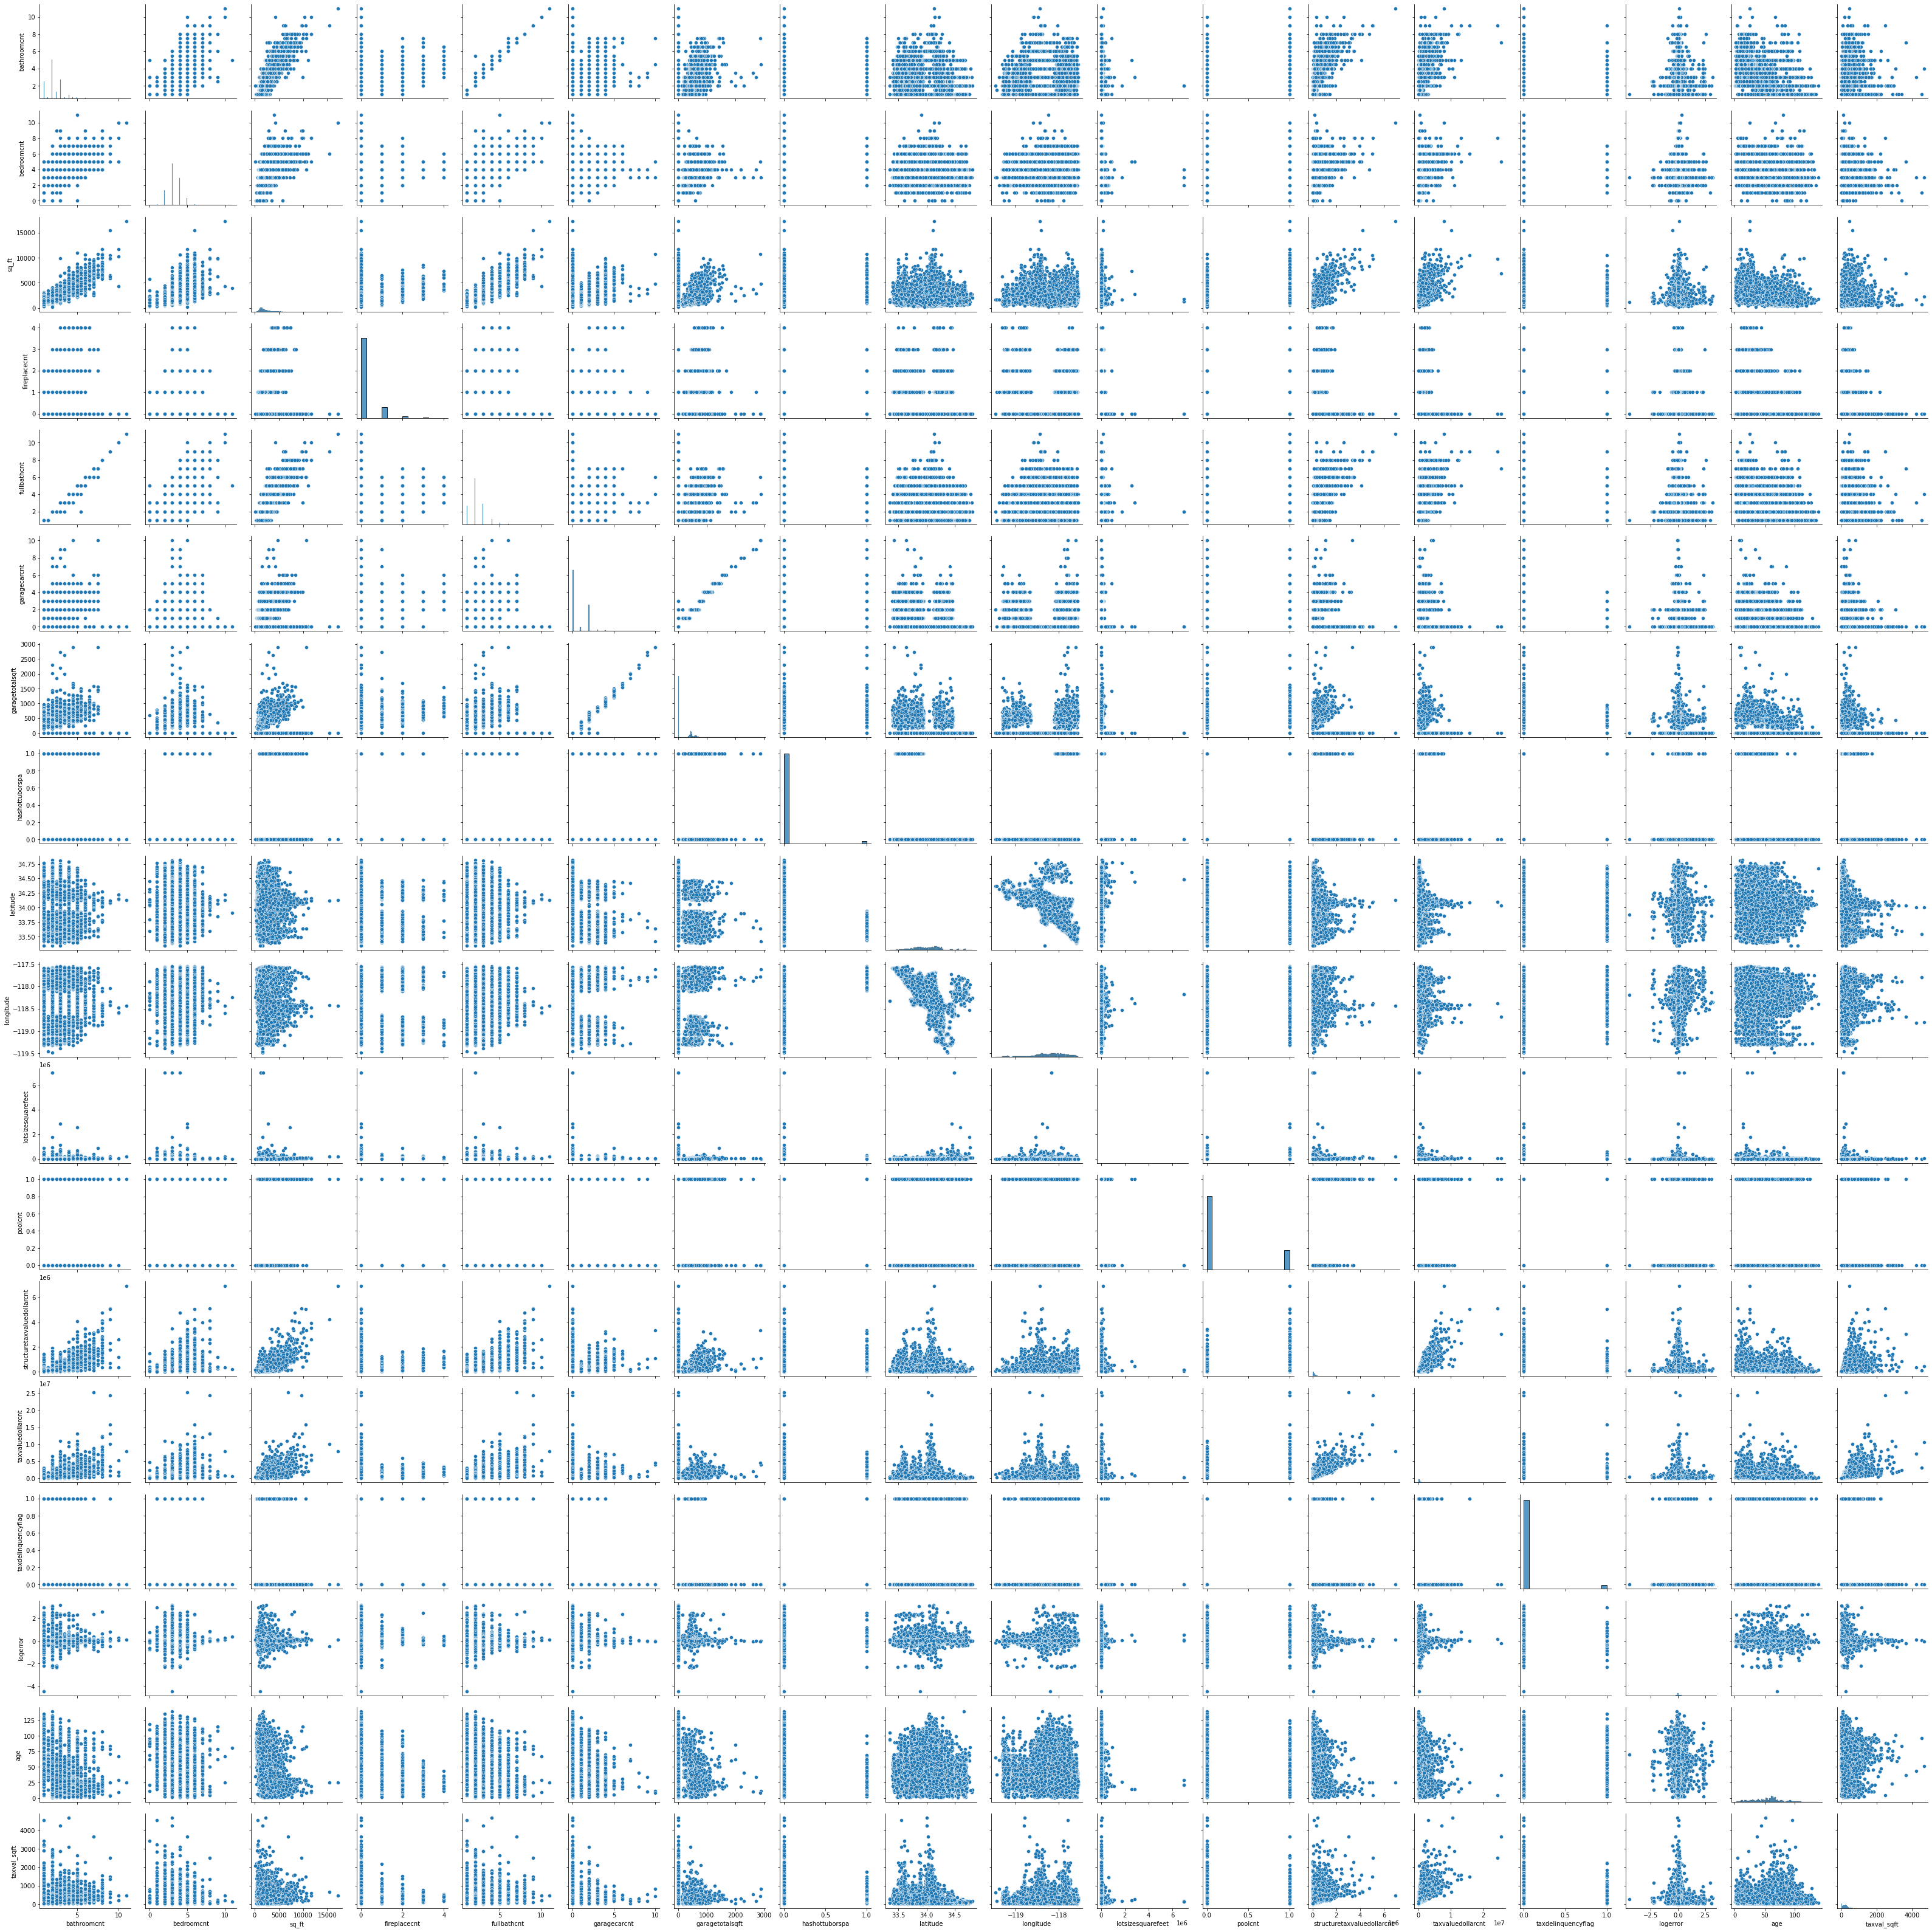

In [16]:
sns.pairplot(train)

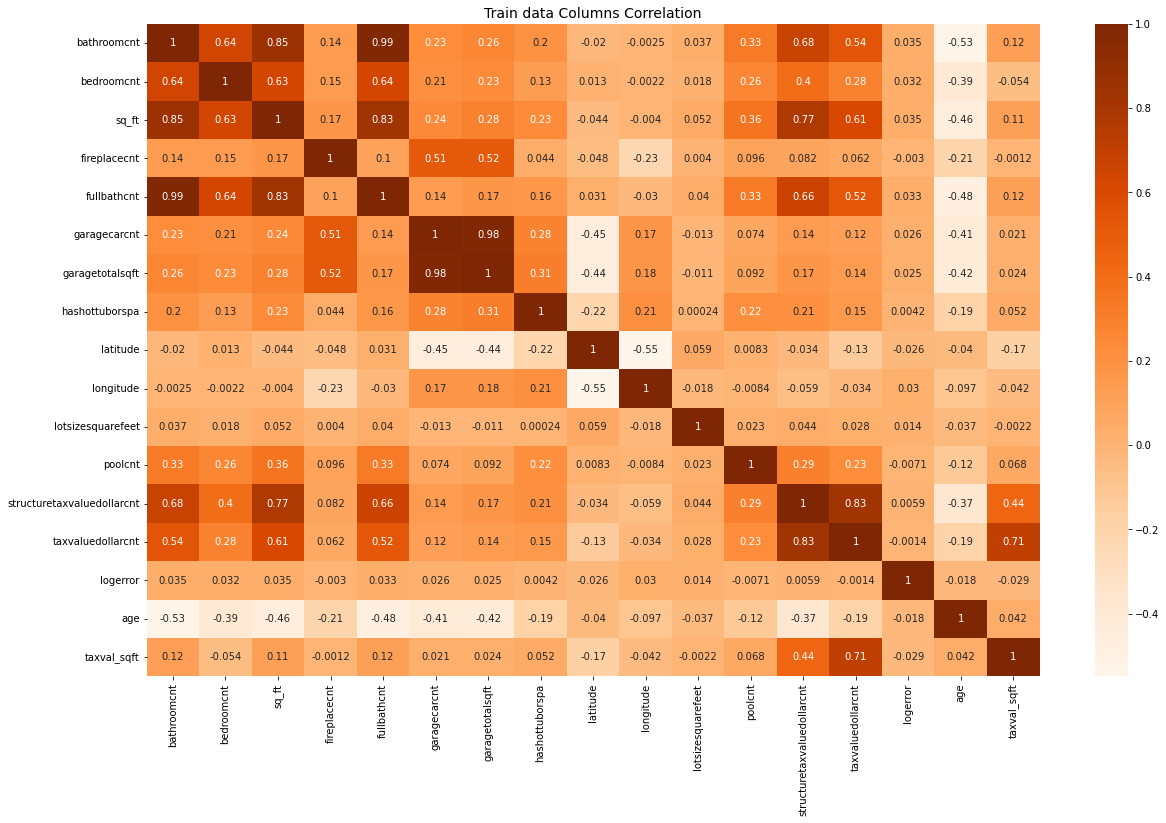

In [17]:
plt.figure(figsize=(20, 12))
sns.heatmap(train.corr(), cmap='Oranges', annot=True)
plt.title('Train data Columns Correlation', fontsize=14)
plt.show()

In [28]:
def correlations(train):
    plt.figure(figsize=(20, 12))
    sns.heatmap(train.corr(), cmap='Oranges', annot=True)
    plt.title('Train data Columns Correlation', fontsize=14)
    plt.show()

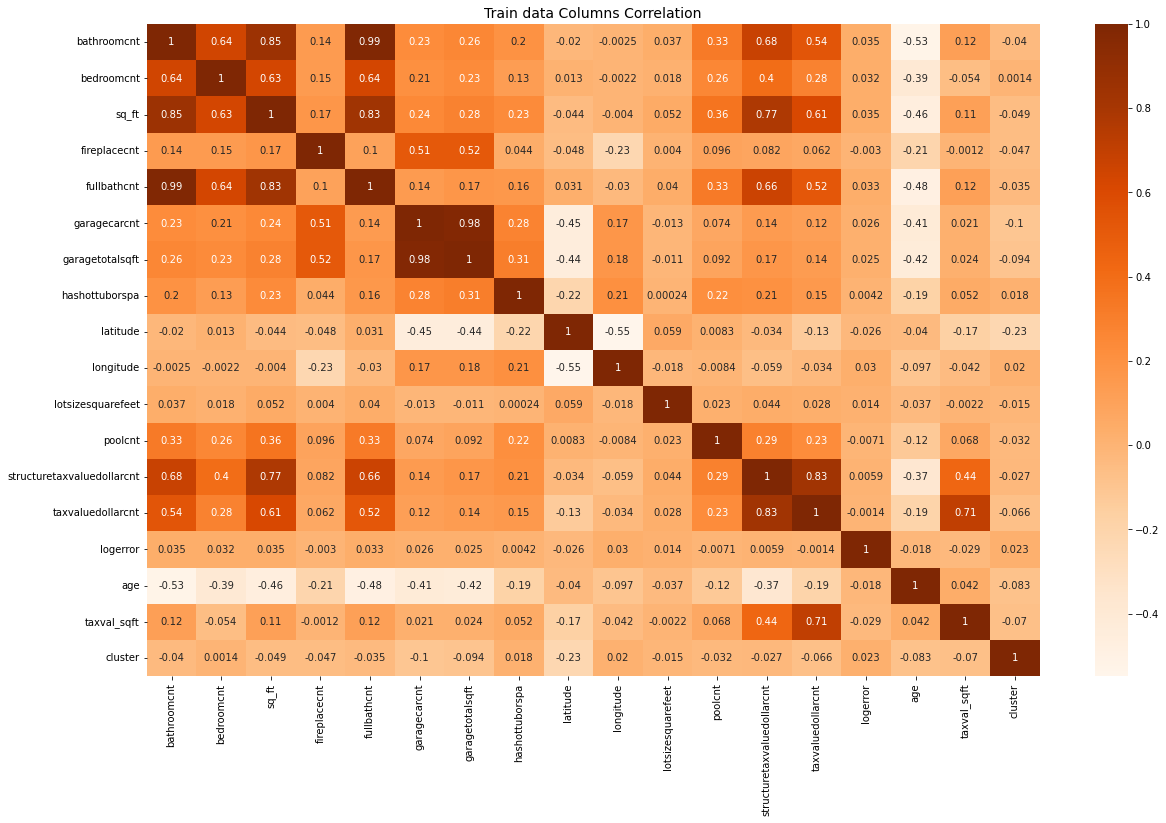

In [29]:
correlations(train)

In [18]:
def value_correlations(train):
    '''
    This functino takes in the zillow train sample and uses pandas and seaborn to create a
    ordered list and heatmap of the correlations between the various quantitative feeatures and the target. 
    '''
    # create a dataframe of correlation values, sorted in descending order
    corr = pd.DataFrame(train.corr().abs().logerror).sort_values(by='logerror', ascending=False)
    # rename the correlation column
    corr.columns = ['correlation (abs)']
    # establish figure size
    plt.figure(figsize=(10,10))
    # creat the heatmap using the correlation dataframe created above
    sns.heatmap(corr, annot=True, cmap="mako")
    # establish a plot title
    plt.title('Features\' Correlation with logerror')
    # display the plot
    plt.show()

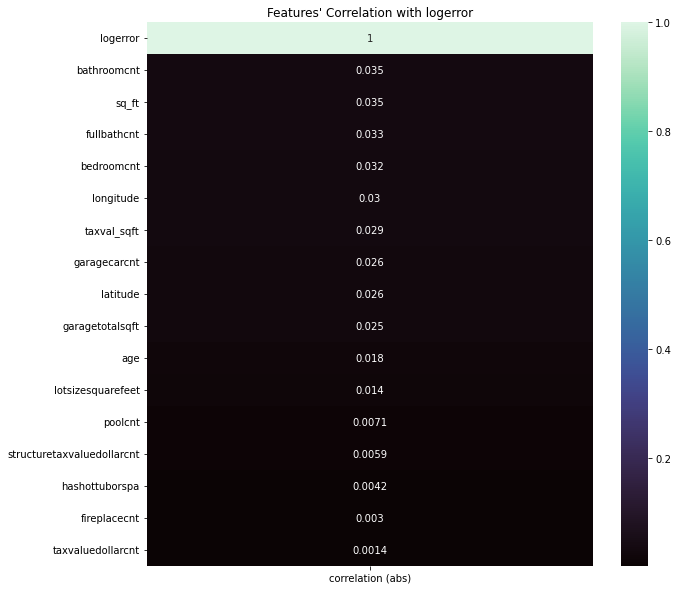

In [19]:
value_correlations(train_scaled)

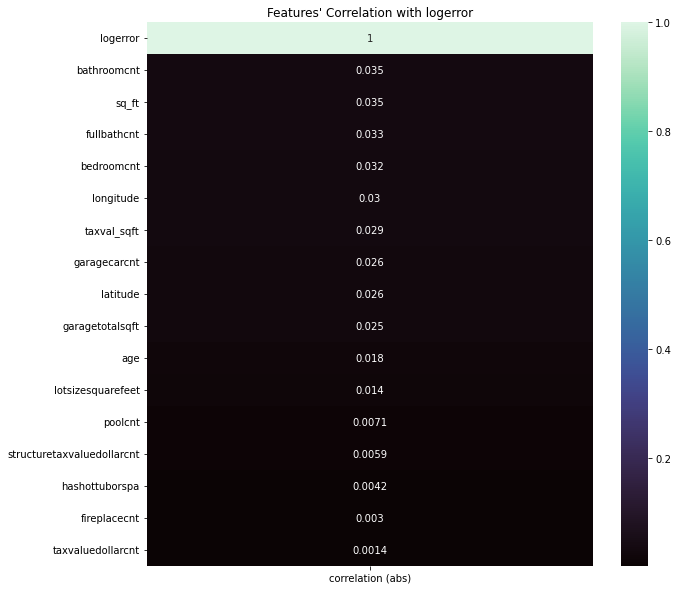

In [20]:
value_correlations(train)

## bed or batch count and logerror

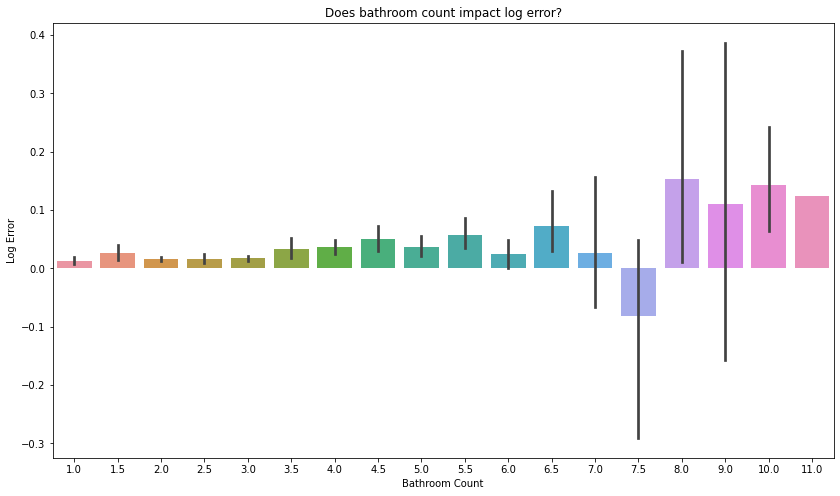

In [23]:
plt.figure(figsize=(14,8))
with sns.color_palette('mako'):
    sns.barplot(x='bathroomcnt', y='logerror', data=train)
plt.xlabel('Bathroom Count')
plt.ylabel('Log Error')
plt.title('Does bathroom count impact log error?')
plt.show()

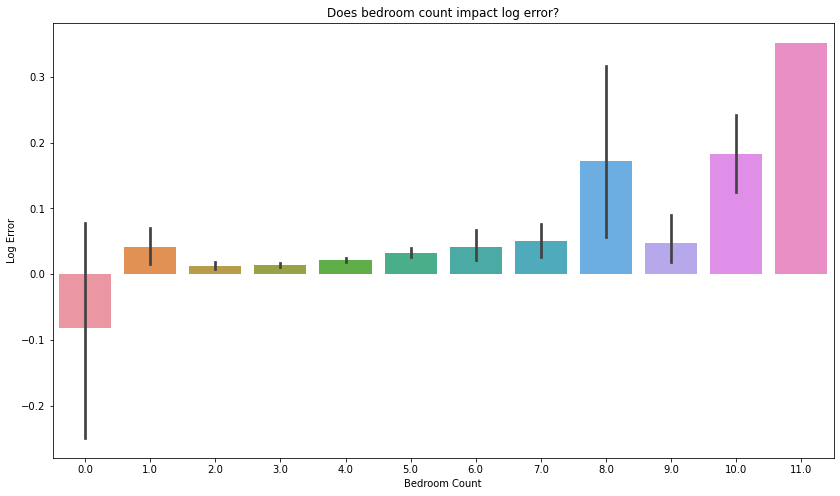

In [24]:
plt.figure(figsize=(14,8))
with sns.color_palette("mako"):
    sns.barplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Log Error')
plt.title('Does bedroom count impact log error?')
plt.show()

## Sq ft and Logerror

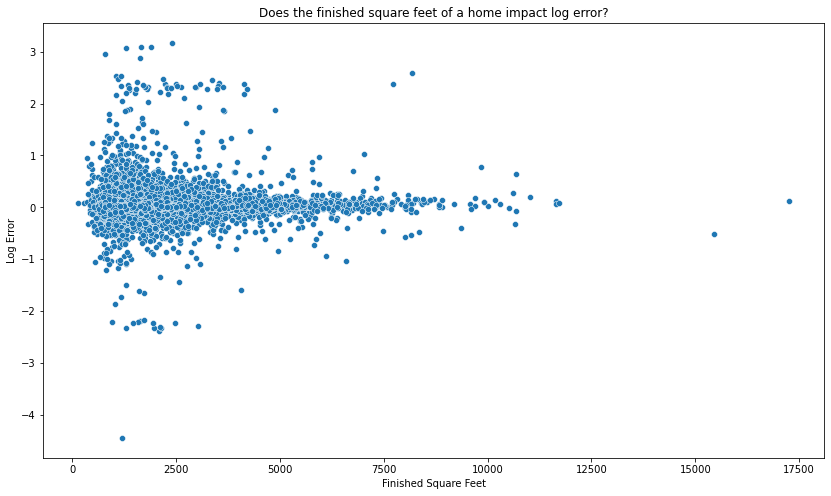

In [26]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='sq_ft', y='logerror', data=train)
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')
plt.title('Does the finished square feet of a home impact log error?')
plt.show()

In [ ]:
## tax val / SQFT and logerror

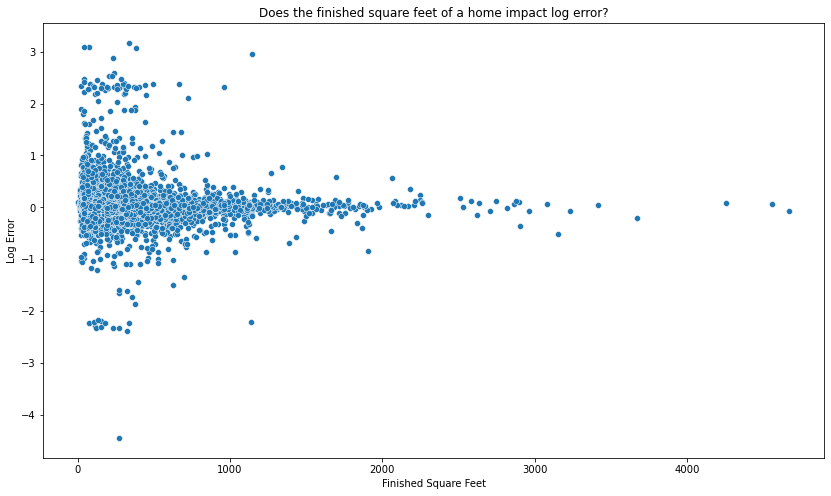

In [27]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='taxval_sqft', y='logerror', data=train)
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')
plt.title('Does the finished square feet of a home impact log error?')
plt.show()

# Clustering

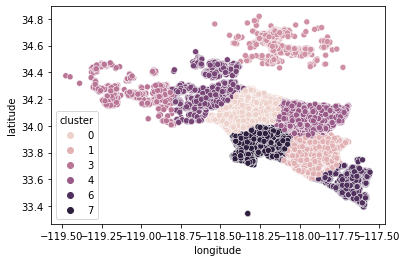

In [22]:
sns.scatterplot(x='longitude', y = 'latitude', data=train, hue='cluster')
plt.show()

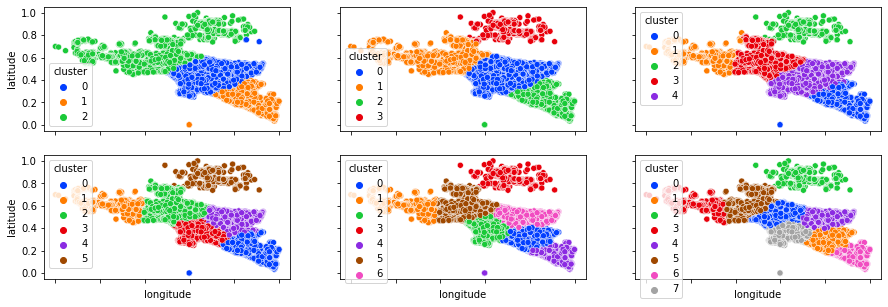

In [45]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True, sharex=True)

for i, k in enumerate(range(3,9)):
    
    # creating clusters with KMeans
    x = train_scaled[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=k, random_state=77)
    kmeans.fit(x)
    train_scaled['cluster'] = kmeans.predict(x)

    # visualize the clusters
    y = int(i / 3)
    x = i % 3
    ax = sns.scatterplot(data=train_scaled, x='longitude', y='latitude', hue='cluster',
                         palette='bright', ax=axes[y,x])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [48]:
for k in range(3, 9):

    # creating clusters with KMeans
    x = train_scaled[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    kmeans.fit(x)
    train['cluster'] = kmeans.predict(x)

    # testing whether there is a significant difference in logerror among the clusters
    alpha = .05
    args = []
    for x in range(k):
        args.append(train_scaled[train_scaled.cluster == x].logerror)
    stat, p = stats.f_oneway(*args)
    
    print('-' * 50)
    print('n_clusters = ', k)
    print('stat = ', stat)
    print('p = ', p)
    if p < alpha:
        print('reject H0')
    else: print('fail to reject H0')

--------------------------------------------------
n_clusters =  3
stat =  19.990989458119262
p =  2.1495102558228478e-09
reject H0
--------------------------------------------------
n_clusters =  4
stat =  14.389172273827807
p =  2.3405184877644606e-09
reject H0
--------------------------------------------------
n_clusters =  5
stat =  14.757656007036324
p =  4.850057163897447e-12
reject H0
--------------------------------------------------
n_clusters =  6
stat =  14.050645320492382
p =  9.560365279227692e-14
reject H0
--------------------------------------------------
n_clusters =  7
stat =  14.266250067085199
p =  2.657506695824041e-16
reject H0
--------------------------------------------------
n_clusters =  8
stat =  12.221137729919224
p =  1.0707764284418793e-15
reject H0


In [ ]:
df.info()

In [34]:
sns.scatterplot(x='sq_ft', y = 'latitude', data=train, hue='logerror', palette='bright')
plt.show()


KeyboardInterrupt



Error in callback <function flush_figures at 0x7fee8c7924c0> (for post_execute):



KeyboardInterrupt



In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True, sharex=True)

for i, k in enumerate(range(3,9)):
    
    # creating clusters with KMeans
    x = train_scaled[['age', 'logerror']]
    kmeans = KMeans(n_clusters=k, random_state=77)
    kmeans.fit(x)
    train['cluster'] = kmeans.predict(x)

    # visualize the clusters
    y = int(i / 3)
    x = i % 3
    ax = sns.scatterplot(data=train, x='age', y='logerror', hue='cluster',
                         palette='bright', ax=axes[y,x])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), sharey=True, sharex=True)

for i, k in enumerate(range(3,9)):
    
    # creating clusters with KMeans
    x = train_scaled[['logerror', 'sq_ft']]
    kmeans = KMeans(n_clusters=k, random_state=77)
    kmeans.fit(x)
    train['cluster'] = kmeans.predict(x)

    # visualize the clusters
    y = int(i / 3)
    x = i % 3
    ax = sns.scatterplot(data=train, x='logerror', y='sq_ft', hue='cluster',
                         palette='bright', ax=axes[y,x])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28967 entries, 7677 to 19248
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   bathroomcnt                 28967 non-null  float64
 1   bedroomcnt                  28967 non-null  float64
 2   sq_ft                       28967 non-null  float64
 3   county                      28967 non-null  object 
 4   fireplacecnt                28967 non-null  float64
 5   fullbathcnt                 28967 non-null  float64
 6   garagecarcnt                28967 non-null  float64
 7   garagetotalsqft             28967 non-null  float64
 8   hashottuborspa              28967 non-null  float64
 9   latitude                    28967 non-null  float64
 10  longitude                   28967 non-null  float64
 11  lotsizesquarefeet           28967 non-null  float64
 12  poolcnt                     28967 non-null  float64
 13  structuretaxvaluedollarcnt  

In [37]:
x = train[['bathroomcnt', 'sq_ft']]
kmeans = KMeans(n_clusters = 4)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)
train.head()

,bathroomcnt,bedroomcnt,sq_ft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxdelinquencyflag,logerror,propertylandusedesc,hot_tub_or_spa,age,taxval_sqft,cluster
7677,5.0,4.0,2924.0,LA County,0.0,5.0,0.0,0.0,0.0,34.156292,-118.589057,5456.0,0.0,373827.0,934051.0,1,0.003152,Single Family Residential,0,10,319.442886,2
12608,2.0,3.0,1502.0,LA County,0.0,2.0,0.0,0.0,0.0,34.490642,-118.621012,12405.0,0.0,274105.0,406963.0,0,0.004674,Single Family Residential,0,52,270.947403,3
44211,2.0,3.0,1100.0,LA County,0.0,2.0,0.0,0.0,0.0,34.198809,-118.520349,6720.0,0.0,208047.0,457702.0,0,-0.037723,Single Family Residential,0,68,416.092727,3
44400,2.0,3.0,1482.0,LA County,0.0,2.0,0.0,0.0,0.0,33.848860,-118.154395,5103.0,0.0,105200.0,522000.0,0,-0.014083,Single Family Residential,0,65,352.226721,3
30257,3.0,4.0,2004.0,Orange County,0.0,3.0,1.0,390.0,0.0,33.784646,-117.942175,7600.0,0.0,150164.0,458497.0,0,-0.096859,Single Family Residential,0,64,228.790918,0


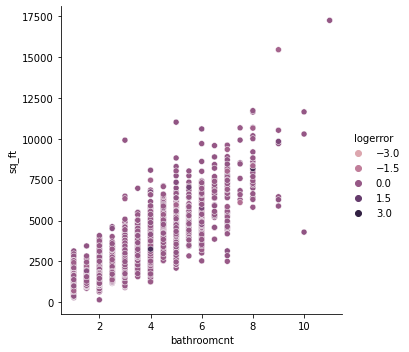

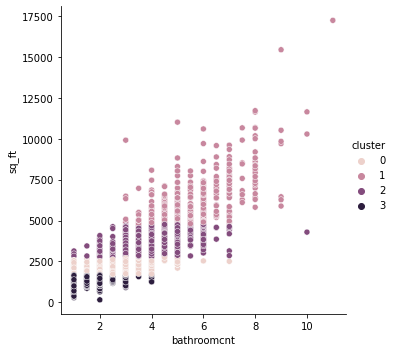

In [38]:

sns.relplot(data=train, x='bathroomcnt', y='sq_ft', hue='logerror')
plt.show()
sns.relplot(data=train, x='bathroomcnt', y='sq_ft', hue='cluster')
plt.show()

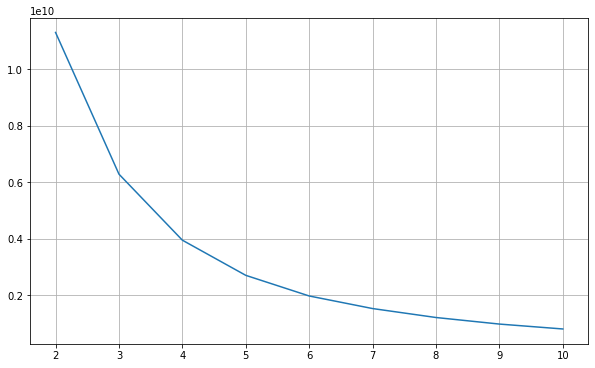

In [39]:
inertias = {}

for k in range(2,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_
plt.figure(figsize=(10,6))
pd.Series(inertias).plot()
plt.grid()
plt.show()

In [45]:
x = train[['bathroomcnt', 'bedroomcnt']]
kmeans = KMeans(n_clusters = 3)
kmeans.fit(x)
train['cluster'] = kmeans.predict(x)
train.head()

,bathroomcnt,bedroomcnt,sq_ft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxdelinquencyflag,logerror,propertylandusedesc,hot_tub_or_spa,age,taxval_sqft,cluster
7677,5.0,4.0,2924.0,LA County,0.0,5.0,0.0,0.0,0.0,34.156292,-118.589057,5456.0,0.0,373827.0,934051.0,1,0.003152,Single Family Residential,0,10,319.442886,1
12608,2.0,3.0,1502.0,LA County,0.0,2.0,0.0,0.0,0.0,34.490642,-118.621012,12405.0,0.0,274105.0,406963.0,0,0.004674,Single Family Residential,0,52,270.947403,2
44211,2.0,3.0,1100.0,LA County,0.0,2.0,0.0,0.0,0.0,34.198809,-118.520349,6720.0,0.0,208047.0,457702.0,0,-0.037723,Single Family Residential,0,68,416.092727,2
44400,2.0,3.0,1482.0,LA County,0.0,2.0,0.0,0.0,0.0,33.848860,-118.154395,5103.0,0.0,105200.0,522000.0,0,-0.014083,Single Family Residential,0,65,352.226721,2
30257,3.0,4.0,2004.0,Orange County,0.0,3.0,1.0,390.0,0.0,33.784646,-117.942175,7600.0,0.0,150164.0,458497.0,0,-0.096859,Single Family Residential,0,64,228.790918,1


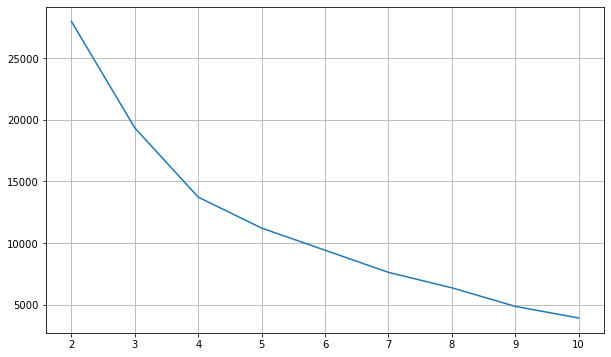

In [46]:
inertias = {}

for k in range(2,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(x)
    inertias[k] = kmeans.inertia_
plt.figure(figsize=(10,6))
pd.Series(inertias).plot()
plt.grid()
plt.show()

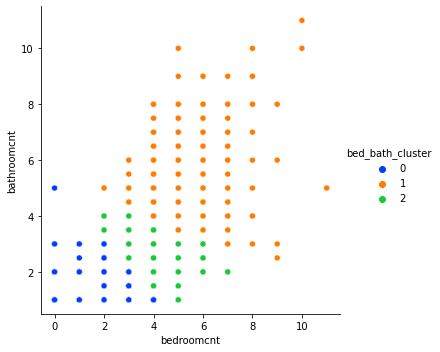

In [38]:
# creating clusters with KMeans
x = train_scaled[['bedroomcnt', 'bathroomcnt']]
kmeans = KMeans(n_clusters = 3, random_state=random_state)
kmeans.fit(x)
train_scaled['bed_bath_cluster'] = kmeans.predict(x)

# visualize the clusters
sns.relplot(data=train, x='bedroomcnt', y='bathroomcnt', hue='bed_bath_cluster', palette='bright')
plt.show()

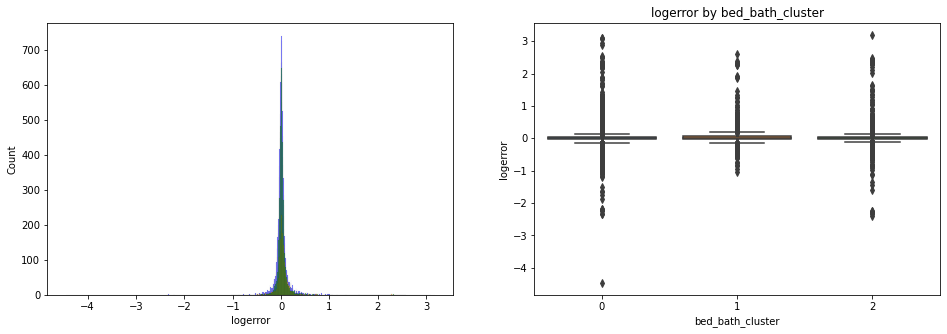

In [39]:
# visualize logerrror by bed_bath_cluster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
plt.title('logerror by bed_bath_cluster')
sns.histplot(train[train_scaled.bed_bath_cluster == 0].logerror, color='blue', alpha = .5, ax=ax1)
sns.histplot(train[train_scaled.bed_bath_cluster == 1].logerror, color='orange', alpha = .5, ax=ax1)
sns.histplot(train[train_scaled.bed_bath_cluster == 2].logerror, color='green', alpha = .5, ax=ax1)
sns.boxplot(data=train_scaled, x='bed_bath_cluster', y='logerror', ax=ax2)
plt.show()

In [31]:
def add_clusters(train_scaled, validate_scaled, test_scaled):
    '''
    This function takes in the train, validate, and test samples from the zillow dataset.
    It then performs clustering on various combinations of features in the train sample, 
    Those clusters are then given useful names where appropriate, and added
    as categorical features to the dataset.
    The train, validate, and test df's are returned, in that order.
    '''
    
    # cluster_BedBath

    # identify features
    features = ['bedroomcnt', 'bathroomcnt']
    # create the df to cluster on 
    x = train_scaled[features]
    # create and fit the KMeans object
    kmeans = KMeans(n_clusters=3, random_state=random_state)
    kmeans.fit(x)

    # create cluster labels for each of the samples and add as an additional column
    for sample in [train_scaled, validate_scaled, test_scaled]:
        x = sample[features]
        sample['cluster_BedBath'] = kmeans.predict(x)
        sample['cluster_BedBath'] = sample.cluster_BedBath.map({1:'low', 0:'mid', 2:'high'})

    # repeat the process for each of the desired feature combinations on which to cluster

    # cluster_BedBathSqft

    features = ['bedroomcnt', 'bathroomcnt', 'sq_ft']
    x = train_scaled[features]
    kmeans = KMeans(n_clusters=3, random_state=random_state)
    kmeans.fit(x)

    for sample in [train_scaled, validate_scaled, test_scaled]:
        x = sample[features]
        sample['cluster_BedBathSqft'] = kmeans.predict(x)
        sample['cluster_BedBathSqft'] = sample.cluster_BedBathSqft.map({1:'low', 0:'mid', 2:'high'})

    
    # cluster_BedBathTaxvaluepersqft
    features = ['bedroomcnt', 'bathroomcnt', 'taxval_sqft']
    x = train[features]
    kmeans = KMeans(n_clusters=3, random_state=random_state)
    kmeans.fit(x)

    for sample in [train_scaled, validate_scaled, test_scaled]:
        x = sample[features]
        sample['cluster_BedBathTaxvaluepersqft'] = kmeans.predict(x)
        sample['cluster_BedBathTaxvaluepersqft'] = sample.cluster_BedBathTaxvaluepersqft.astype(str)
    
        
    # cluster_LatLong
    features = ['latitude', 'longitude']
    x = train[features]
    kmeans = KMeans(n_clusters=4, random_state=random_state)
    kmeans.fit(x)

    for sample in [train_scaled, validate_scaled, test_scaled]:
        x = sample[features]
        sample['cluster_LatLong'] = kmeans.predict(x)
        sample['cluster_LatLong'] = sample.cluster_LatLong.map({0:'east', 1:'central', 2:'west', 3:'north'})


    return train_scaled, validate_scaled, test_scaled

In [32]:
train_scaled, validate_scaled, test_scaled = add_clusters(train_scaled, validate_scaled, test_scaled)

In [40]:
train_scaled.head()

,bathroomcnt,bedroomcnt,sq_ft,county,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,latitude,longitude,lotsizesquarefeet,poolcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,taxdelinquencyflag,logerror,propertylandusedesc,hot_tub_or_spa,age,taxval_sqft,cluster_BedBath,cluster_BedBathSqft,cluster_BedBathTaxvaluepersqft,cluster_LatLong,bed_bath_cluster
7677,0.4,0.363636,0.162172,LA County,0.0,0.4,0.0,0.000000,0.0,0.551620,0.461458,0.000749,0.0,0.053904,0.036677,1,0.003152,Single Family Residential,0,0.065217,0.067361,low,low,0,north,1
12608,0.1,0.272727,0.078980,LA County,0.0,0.1,0.0,0.000000,0.0,0.777917,0.444821,0.001746,0.0,0.039519,0.015908,0,0.004674,Single Family Residential,0,0.369565,0.056960,mid,mid,0,north,0
44211,0.1,0.272727,0.055461,LA County,0.0,0.1,0.0,0.000000,0.0,0.580396,0.497229,0.000930,0.0,0.029990,0.017907,0,-0.037723,Single Family Residential,0,0.485507,0.088089,mid,mid,0,north,0
44400,0.1,0.272727,0.077810,LA County,0.0,0.1,0.0,0.000000,0.0,0.343542,0.687752,0.000698,0.0,0.015154,0.020441,0,-0.014083,Single Family Residential,0,0.463768,0.074392,mid,mid,0,north,0
30257,0.2,0.363636,0.108348,Orange County,0.0,0.2,0.1,0.134436,0.0,0.300080,0.798239,0.001056,0.0,0.021640,0.017938,0,-0.096859,Single Family Residential,0,0.456522,0.047919,high,high,0,north,2
